# Neural Nets Tutorial - Part 4 (Draft)

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

<p style="font-weight:600; font-family:'Helvetica';font-size:24px;color:blue">
Classification with a neural network
</p>


We can also train our model on a classification task.  In a classification task, we want the network to predict which category something belongs to.  In this lesson, we're going to predict if an object detected by a telescope is a star, a galaxy, or a quasar.

We could do this with regression, and have our output be `1`, `2`, or `3` to indicate a star, a galaxy, or a quasar.  There are issues with this, though:

- In the forward pass of a neural network, we multiply by the weights to get the output.  Let's say we predict a `1`, but we actually should have predicted a `2`.  We would need to increase the weights.  But a galaxy isn't twice as large as a star.  So the mapping doesn't make sense in the context of the input data.
- We can get an intermediate value like `1.5` as a prediction, which is hard to interpret.  We'd ideally want percentages indicating the chance that an example is each of the classes.
- The network can output values below `1` or above `3`.

Classification allows us to solve this problem - it lets us output the probability that an example belongs to each of the classes (star, galaxy, or quasar).  In classification, most of the neural network works the same - the two main things that change are the activation function and the loss function.

<p style="font-size:15px; font-weight:600;color:blue">
We will not be working directly with images, but data extracted from the images and appropriate for a neural network.
</p>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zutils as utils
import pprint as pp
import math

from scipy.interpolate import make_interp_spline

## 1. Binary Classification

In [100]:
from importlib import reload
import os
import sys

# Append the path so we can import the correct library
sys.path.append(os.path.abspath("data"))
sys.path.append(os.path.abspath("nnets"))

import csv_data
reload(csv_data)
from csv_data import SkyServerBinaryDatasetWrapper

# Load in our data.  The wrapper handles the details of loading and processing the data for us.
wrapper = SkyServerBinaryDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

In [101]:
print(train_x[:5])

[[ 0.16745842 -0.58492272  1.03148637 -0.34855938 -0.83728027 -0.94605772
  -0.99534154 -0.83806089  0.21085172 -0.21763043 -0.36973112  1.03148936
   1.30931064]
 [ 0.16886159 -0.58311429  0.05243046 -0.16653251 -0.15415531 -0.08264457
  -0.02604308 -0.83806089  0.21085172 -0.21763043 -0.36984929 -0.63621258
  -0.87919741]
 [ 0.17057433 -0.58347525  0.92156796  0.86709322  0.59315368  0.44120145
   0.31452753 -0.83806089  0.21085172 -0.21147922 -0.05302706 -0.65633905
  -0.60919097]
 [ 0.17455754 -0.58650069 -1.03063038 -0.81362749 -0.63669227 -0.52660429
  -0.43092107 -0.83806089  0.21085172 -0.20532801 -0.36999261  1.03148936
   1.30931064]
 [ 0.17482457 -0.58441247 -1.29023238 -1.17251944 -0.37676237 -0.02510121
   0.15827647 -0.83806089  0.21085172 -0.20532801 -0.36818949  1.03148936
   1.30931064]]


In [102]:
print(train_y[:5])

[[0]
 [0]
 [1]
 [0]
 [0]]


As you can see above, the target is `0` when the object is not a star, and `1` otherwise.  We want our network to output a number between `0` and `1` indicating the probability that the object is a star.  This is called binary classification.  Let's learn how to set our network up to do this.

## Sigmoid activation

In the previous lesson, we didn't apply an activation function to the output of our network - we just output the last layer directly.  But in a binary classification problem, we want to predict either `0` or `1`.  A neural network can output values outside this range, so we need to constrain the outputs.

We can do this using the sigmoid function, which will ensure all outputs are inside the range `0` to `1`.  Mathematically, the sigmoid function is $\Large \sigma=\frac{1}{1 + e^{-x}}$.  $e$ is a special number with a value around `2.71`, with the property that the natural log of $e$ equals `1`.  We use this exact formula because of how it interacts with the loss function (we'll see this later).

Raising the number $e$ to the power $-x$ will result in a number close to `0` when $x$ is high.  This is because a negative exponent is the product of fractions, like $3 ^ {-2}$ is equal to $1/3 * 1/3$.  When $x$ is large, the sigmoid will output a number very close to $1$, because $e^{-x}$ will be close to `0`, and the denominator will be close to `1`.

Raising the number $e$ to the power $-x$ when x is a negative number will make the value of $e^{-x}$ very large.  The negative sign in $e^{-x}$ will undo the negative sign on $x$, so we'll raise $e$ to a large positive power.  This will make the denominator very large, and push the sigmoid close to `0`.

You can see an example here:

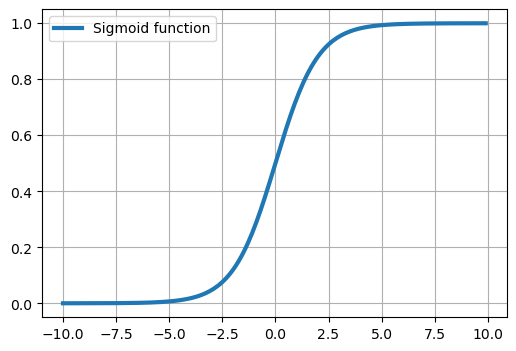

In [103]:
# Create an array of numbers from -10 to 10
nn_outputs = np.arange(-10,10,.1)

# Define the sigmoid function
sigmoid = lambda x: 1 / (1 + np.exp(-x))

plt.figure(figsize=(6,4))
plt.plot(nn_outputs, sigmoid(nn_outputs), linewidth=3, label='Sigmoid function')
plt.legend()
plt.grid()
plt.show()

Our network will output continuous real numbers in the last layer, and the sigmoid function will transform them into probabilities from `0` to `1`.  The sigmoid will output the probability that the example belongs to a given class.  For example, if we code a star as `1`, and everything else as a `0`, the output of the sigmoid activation tells us the probability that an example is a star.  The sigmoid output might be `.51`, corresponding to a 51% probability.

## Negative Log Likelihood

Because the range of values after we apply the sigmoid function is so small, mean squared error isn't the best loss function.  If the actual target is a `1`, and we predict a `.5`, mean squared error will only be `.25`.  Here is how mean squared error looks with binary classification:

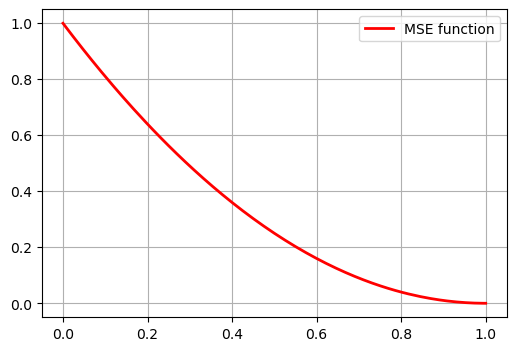

In [14]:
mse = lambda pred, actual: (pred - actual) ** 2
output_probs = sigmoid(nn_outputs)

plt.figure(figsize=(6,4))
plt.plot(output_probs, mse(output_probs, 1), linewidth=2, color='r', label='MSE function')
plt.grid()
plt.legend()
plt.show()

<b>As you can see, mean squared error only ranges between `0` and `1`.</b>  This can make it hard for the network to penalize incorrect guesses and adjust the weights properly.  We instead want a function that will penalize incorrect predictions much more than predictions that are close to the actual value.

We can instead use the negative log likelihood, which is defined for a Bernoulli Distribution as:

$\large NLL = -(y \cdot log(\hat{y}) + (1-y) \cdot log(1-\hat{y}))$.

Since $y$ is always `0` or `1`, one half of the equation will always be `0`.  Let's say $y$ is `1`, and $\hat{y}$ is `.7`.

$$NLL = -(1 \cdot log(.7) + (1-1) \cdot (1-.7))$$
$$NLL = -(1 \cdot log(.7) + 0 \cdot (1-.7))$$
$$NLL = -(1 \cdot log(.7))$$
$$NLL = -(1 \cdot log(.7))$$
$$NLL = .3566$$

Remember that $log .7$ means "to what power do I need to raise $e$ to get `.7`?"  To get a number between `0` and  `1` (which is what the sigmoid function outputs), you have to raise $e$ to a negative power.  Raising to a negative power is the same as repeatedly multiplying $1/e$ by itself.  The closer $\hat{y}$ is to `1`, the lower the negative power (the further from `0`).

You then "undo" the negative with the beginning negative sign for negative log likelihood.  Note that $log 0$ is undefined, so we have to be careful not to pass `0` in as our prediction.  Luckily, the sigmoid function cannot output `0`, since the sigmoid is $\large 1/(1+e^{-x})$.  As $\large e^{-x}$ increases, the sigmoid outputs numbers closer and closer to `0`, but never reaches `0`.

Let's see how negative log likelihood changes as we change our predictions.  We're assuming that the correct target is `1`:

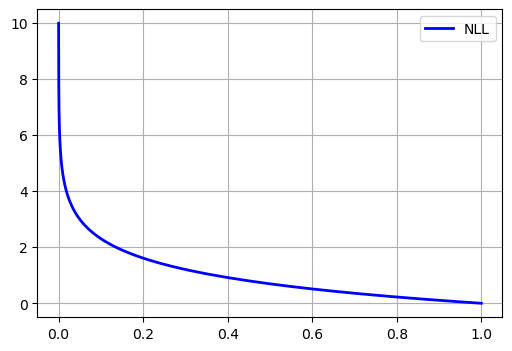

In [15]:
# Define negative log likelihood function
# Add a small tolerance to avoid taking a log close to 0
tol = 1e-6
nll = lambda pred, actual: -(actual * np.log(pred + tol) + (1-actual) * np.log((1-pred + tol)))

# Plot negative log likelihood against our simulated output probabilities
plt.figure(figsize=(6,4))
plt.plot(output_probs, nll(output_probs, 1), linewidth=2, color='blue', label='NLL')
plt.grid()
plt.legend()
plt.show()


We can see that negative log likelihood gets very large as our prediction gets closer to `0`.  This loss function will penalize big errors in predictions more than mean squared error.

## Training Loop - Binary Classification

We now know enough to try binary classification using our neural network.  We'll run the network normally, but apply the sigmoid function to the output layer, then measure error with negative log likelihood.

In the last lesson, we trained a neural network to make predictions.  We'll use the same code as last time, but this time we'll define our neural network using a class.  This helps us avoid rewriting all of the same code from last time again.

We'll define a neural network with 2 layers.  Layer 1 will take in 13 input features, and convert them into 25 features.  Layer 2 will take those 25 features, and turn them into a single output.

In [104]:
from dense import Dense

class ClassificationNet():
    def __init__(self, output_size=1):
        # Setup 2 neural network layers.  Each Dense class is a single network layer.
        # We don't use relu activation on the second layer, but we do in the first layer.
        self.layer1 = Dense(input_size=13, output_size=25)
        self.layer2 = Dense(input_size=25, output_size=output_size, activation=False)

    def forward(self, x):
        # In the forward pass, we take in input data, and run our 2 layers over the data.
        x = self.layer1.forward(x)
        x = self.layer2.forward(x)
        return x

    def backward(self, grad, lr):
        # In the backward pass, we take the gradient and learning rate, and use them to adjust parameters in each layer.
        grad = self.layer2.backward(grad, lr)
        self.layer1.backward(grad, lr)


def plot_data(X, Y, smooth=False, smooth_pts=50, x_label='epoch', y_label='MSE-train'):
    Y_min = min(Y)
    X_min = X[Y.index(Y_min)]
    
    deltaX = X[1] - X[0]
    
    annot_X = (max(X)-min(X)) // 2 + deltaX
    annot_Y = (max(Y)-min(Y)) // 2
    arrowprops = dict(facecolor='black', shrink=0.08)
    
    plt.figure(figsize=(9,5))
    if smooth:
        XY_Spline = make_interp_spline(X, Y, k=3)
        # Returns evenly spaced numbers
        # over a specified interval.
        Xs = np.linspace(min(X), max(X), smooth_pts)
        Ys = XY_Spline(Xs)
        plt.plot(Xs, Ys, linestyle='--', marker='o', markersize=7, markerfacecolor='k', 
                 color='b', label=y_label + ':splines fit', linewidth=2)
    else:
        plt.plot(X, Y, linestyle='--', marker='o', markersize=7, markerfacecolor='k', 
                 color='b', label=y_label, linewidth=2)

    plt.annotate(f'Min({y_label}) = {Y_min:.3f}', xy=[X_min, Y_min], xytext=[annot_X, annot_Y], 
                     arrowprops=arrowprops, fontsize=14)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(X, minor=False)
    #plt.ylim(bottom=20, top=40) # ylim(bottom=value1, top=value2)
    plt.grid()
    plt.legend()
    plt.show()

As mentioned earlier, our network will output a single number in the last layer - let's call this $z$.  We'll then run the sigmoid function over $z$ to get the output probability $p$.  We'll then use a loss function $L$ (negative log likelihood) to calculate how far we were from the actual target.

The derivative of the loss function $L$ with respect to the predicted probabilities $p$ is $\large \frac{\partial L}{\partial p}=\frac{p-y}{p(1-p)}$.  And the derivative across the sigmoid function of the probabilities $p$ with respect to the neural network output $z$ is $\large \frac{\partial p}{\partial z}=p(1-p)$.  If we want to compute the partial derivative of the loss $L$ with respect to the neural network output $z$, we multiply the two by the chain rule:

$$\large \frac{\partial L}{\partial z} = \frac{\partial L}{\partial p} \cdot \frac{\partial p}{\partial z}$$
$$\large \frac{\partial L}{\partial z} = \frac{p-y}{p(1-p)} \cdot \frac{\partial p}{\partial z}=p(1-p)$$
$$\large \frac{\partial L}{\partial z} = p - y$$

Luckily for us, the denominator multiplies out, and we're left with $\large p-y$, or the predicted probabilities minus the target.  So in one step, we'll calculate the gradient with respect to the output of our neural network.

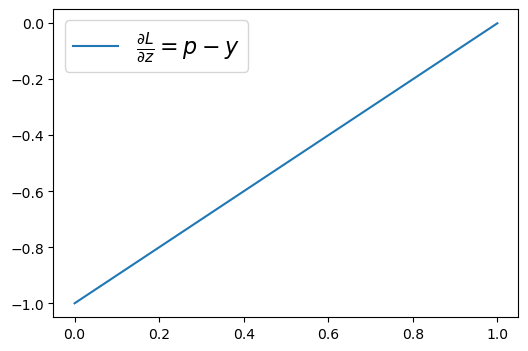

In [22]:
# Computes the gradient with respect to the outputs of the neural network
# Input will be the sigmoid function applied to the neural network outputs
nll_grad = lambda pred, actual: pred - actual

# plt.rcParams['text.usetex'] = True

plt.figure(figsize=(6,4))
plt.plot(output_probs, nll_grad(output_probs, 1), label=r'$\frac{\partial L}{\partial z} = p - y$')
plt.legend(fontsize='16')
plt.show()

### Training loop implementation

Epoch 0 train loss: 0.2682695827790348 - Valid loss: 0.2644771902817305
Epoch 5 train loss: 0.13331082109801323 - Valid loss: 0.1583456484832132
Epoch 10 train loss: 0.10104581465738748 - Valid loss: 0.12039744183988188
Epoch 15 train loss: 0.08425752461086093 - Valid loss: 0.10458910783486372
Epoch 20 train loss: 0.07648901768969218 - Valid loss: 0.09312973342784746
Epoch 25 train loss: 0.07112076834950228 - Valid loss: 0.09613885645765395
Epoch 30 train loss: 0.06804528798961351 - Valid loss: 0.09299463791060265
Epoch 35 train loss: 0.06458050551979588 - Valid loss: 0.08907962927098297
Epoch 40 train loss: 0.062478921931811975 - Valid loss: 0.09788190123806975
Epoch 45 train loss: 0.06103894423865766 - Valid loss: 0.10253824339200511


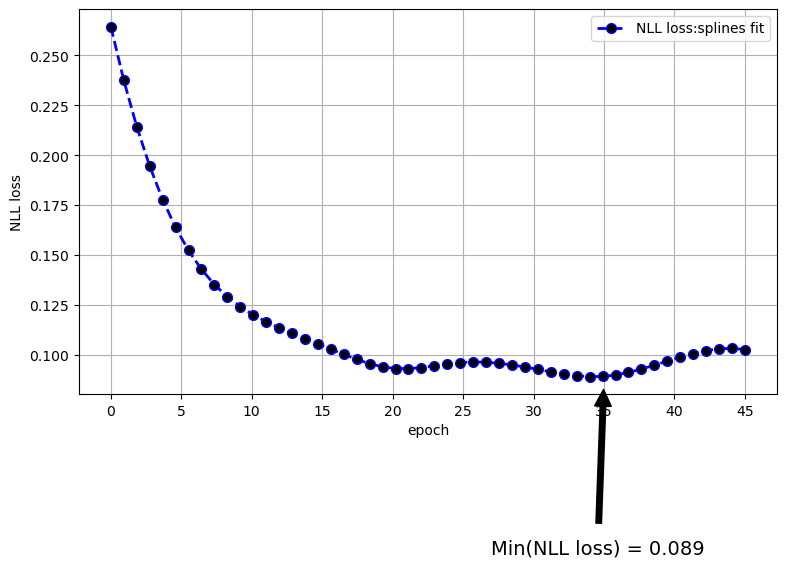

In [107]:
net = ClassificationNet(1)
lr = 1e-2
epochs = 50

train_loss_data = []
valid_loss_data = []
epoch_data = []

for epoch in range(epochs):
    train_loss = 0
    for x, target in zip(train_x, train_y):
        # Run the sigmoid function over the output of the neural network
        pred = sigmoid(net.forward(x.reshape(1,-1)))
        
        # Compute the gradient using the nll_grad function
        grad = nll_grad(pred, target)
        # nll() is a single value  np.array, i.e. [[value]]
        train_loss += nll(pred, target)[0,0] 

        # Update the network parameters
        net.backward(grad, lr)
    
    if epoch % 5 == 0:
        # print(f"Epoch {epoch} train loss: {train_loss / len(train_x)}")
        epoch_data.append(epoch)
        train_loss_data.append(train_loss / len(train_x))
        valid_loss = 0
        for x, target in zip(valid_x, valid_y):
            pred = sigmoid(net.forward(x.reshape(1,-1)))
            valid_loss += nll(pred, target)[0,0]

        valid_loss_data.append(valid_loss / len(valid_x))
        print(f"Epoch {epoch} train loss: {train_loss / len(train_x)} - Valid loss: {valid_loss / len(valid_x)}")

plot_data(epoch_data, valid_loss_data, smooth=True, y_label='NLL loss')

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)

## 2. Multi-class Classification

Now that we've covered binary classification, let's cover classification with multiple targets.  Let's say that our telescope can id `3` different kinds of objects, and we want to know the probability that it has detected each one.  These 3 objects are stars, galaxies, and quasars.

We can't use binary classification, since that can only tell us if a single object is present or not.  We'll instead need to use multi-class classification.

Our first step is to <b>encode our targets into one-hot vectors</b>.  Each position in the vector will correspond to a single class.  We'll say that a star corresponds to position `0`, a galaxy to position `1`, and a quasar to position `2`:

In [68]:
def encode(target, max_value=3):
    encoded = np.zeros((1,max_value))
    encoded[0,target] = 1
    return encoded

# Encode a star
print("One-hot vector for 'STAR':  ", encode(0))

# Encode a galaxy
print("One-hot vector for 'GALAXY':", encode(1))

# Encode a quasar
print("One-hot vector for 'QUASAR':", encode(2))

One-hot vector for 'STAR':   [[1. 0. 0.]]
One-hot vector for 'GALAXY': [[0. 1. 0.]]
One-hot vector for 'QUASAR': [[0. 0. 1.]]


As you can see above, we end up with a 3-element vector after encoding.  The position in the vector that is `1` corresponds to our class label (star, galaxy, or quasar).  This is why it is called one-hot encoding - only one position in the vector is non-zero.

We'll use our network to predict this vector by outputting 3 number.  Similar to what we did with the sigmoid function, we need a way for the network to output values between `0` and `1` for each position in the vector.

We also need <b>all of the elements in the output vector to add to `1`</b>.  Each vector element is the <b>probability</b> that the item belongs to that class.  Our total probability has to be `100%`.

## Softmax Function

The softmax function will normalize the values in our output vector to meet the criteria above:

$\huge \zeta=\frac{e^{\hat{y_{i}}}}{\sum_{j=0}e^{\hat{y_{j}}}}$

Confusingly, the softmax and sigmoid functions usually the same symbol to define them.  To eliminate that confusion, we'll use $\zeta$ for softmax.  Intuitively, the softmax will raise the current prediction to the power $e^{y_{i}}$, then divide by the sum of all the other predictions.  Larger predictions will get pushed closer to `1`, and smaller predictions will get pushed closer to `0`.  This is why it is called a softmax - it is a "softer" way of taking the maximum of the vector.

Let's take a look at the function:

In [73]:
def softmax(preds):
    # Raise e to the power of each of the predictions
    preds_max = np.max(preds)
    preds = np.exp(preds)
    # Divide the predictions by the sum
    # Handle matrix or vector input
    if len(preds.shape) > 1:
        normed = preds / np.sum(preds, axis=1).reshape(-1,1)
    else:
        normed = preds / np.sum(preds)
    return normed

100 (100, 2)
[[ 0.  10. ]
 [ 0.1  9.9]
 [ 0.2  9.8]
 [ 0.3  9.7]
 [ 0.4  9.6]
 [ 0.5  9.5]
 [ 0.6  9.4]
 [ 0.7  9.3]
 [ 0.8  9.2]
 [ 0.9  9.1]]


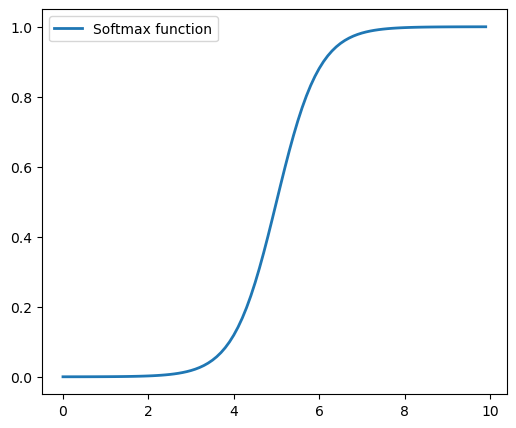

In [81]:
x = np.arange(0,10,.1).reshape(-1,1)
y = np.arange(10,0,-.1).reshape(-1,1)

# print(x[:10])
# print(y[:10])

data1 = np.hstack((x,y))
print(len(data1), data1.shape)
print(data1[:10])
softmaxed = softmax(np.hstack((x,y)))

plt.figure(figsize=(6,5))
plt.plot(x, softmaxed[:,0], linewidth=2, label='Softmax function')
plt.legend()
plt.show()

## Negative Log Likelihood - Cross Entropy

Our earlier negative log likelihood formula only worked for binary classification.  We'll extend it to work with multiple classes, and specifically a vector of probabilities:

$$\Large NLL = - \sum_{i=0} y_{i} \log p_{i}$$

We look at each position in the encoded vector, and multiply it by the log of the prediction at that position.  We then add up all of these values to get the log loss.

Similar to the binary negative log likelihood, the multiclass case will only be non-zero at a single position in the vector.  So we're essentially looking at the position where actual equals `1` times the log of the prediction at that position.  If the prediction is close to `0` at that position, then $log(p)$ will become a large negative number.  If the prediction is close to `1`, then $log(p)$ will get close to `0`.  Since we have a negative sign at the beginning of the log loss formula, this will mean that log loss gets higher if the prediction is further away from the actual value.

This is essentially the same as binary negative log likelihood.  In the binary case, we had to "correct" for the fact that we only had one probability number.  But imagine we had two numbers - one indicating the percentage the observation was a star, and one indicating that it was not.  Both numbers would add to 1, so $\large NLL = -(y * log(\hat{y}) + (1-y) * log(1-\hat{y}))$ (with one output) would be equivalent to $\large NLL = - \sum_{i=0} y_{i} \log p_{i}$ (with 2 outputs).

Let's take a look at how this works:

In [84]:
def multiclass_loss(predicted, actual, print_ce=False):
    # We add a small tolerance to avoid taking the log of 0, which is undefined
    tol = 1e-6
    cross_entropy = actual * np.log(predicted + tol)
    if print_ce:
        print(cross_entropy)
    return -np.sum(cross_entropy)

# An example where the prediction is far from the actual value - loss is high
print('An example where the prediction is far from the actual value - loss is high')
print(multiclass_loss(np.array([0, .2, .8]), np.array([1,0,0]), True))
# An example where the prediction is close to the actual value - loss is low
print('An example where the prediction is close to the actual value - loss is low')
print(multiclass_loss(np.array([.8, .1, .1]), np.array([1,0,0]), True))

An example where the prediction is far from the actual value - loss is high
[-13.81551056  -0.          -0.        ]
13.815510557964274
An example where the prediction is close to the actual value - loss is low
[-0.2231423 -0.        -0.       ]
0.2231423013149909


## Multiclass loss gradient

To find the gradient of $\large \frac{\partial L}{\partial z}$ , we again need to find $\large \frac{\partial L}{\partial p} * \frac{\partial p}{\partial z}$.  To find $\large \frac{\partial L}{\partial p}$ we need to take the derivative of the log loss equation, and multiply by the derivative of the softmax equation.

Similarly to the sigmoid and binary negative log likelihood, the activation and loss largely cancel out, and we end up with the following gradient, which is just $\large \frac{\partial L}{\partial z} = p-y$:

For a derivation of the above relation see:
["Derivative of the Softmax function"](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)

In [87]:
multiclass_loss_grad = lambda pred, actual: pred - actual

## Training Loop - Multiple Classes

We're now ready to write our training loop with multiple classes.  The main differences are:

- `3` outputs instead of `1`
- `softmax` to generate our probabilities instead of `sigmoid`
- `multiclass_loss` to find our error
- we'll encode our target into a one-hot vector before measuring loss

Epoch 0 train loss: 0.5340438424762264 - Valid loss: 0.3692486797180051
Epoch 10 train loss: 0.1707641861177147 - Valid loss: 0.20607680288250774
Epoch 20 train loss: 0.1294487347080184 - Valid loss: 0.1661661400598208
Epoch 30 train loss: 0.10977823237985221 - Valid loss: 0.14806029236884097
Epoch 40 train loss: 0.09653654780216853 - Valid loss: 0.1361370251581223
Epoch 50 train loss: 0.08561741131492749 - Valid loss: 0.124944716804852
Epoch 60 train loss: 0.07673421268814455 - Valid loss: 0.11478209401767127
Epoch 70 train loss: 0.06975139962463613 - Valid loss: 0.10714565450708667
Epoch 80 train loss: 0.0642753670436077 - Valid loss: 0.10087135829758899
Epoch 90 train loss: 0.05993882495191819 - Valid loss: 0.09704722005697285
Epoch 100 train loss: 0.05659007390699589 - Valid loss: 0.09541624122841252
Epoch 110 train loss: 0.053850717572829054 - Valid loss: 0.09405315345460423
Epoch 120 train loss: 0.051593227021303596 - Valid loss: 0.09234051687315685
Epoch 130 train loss: 0.049535

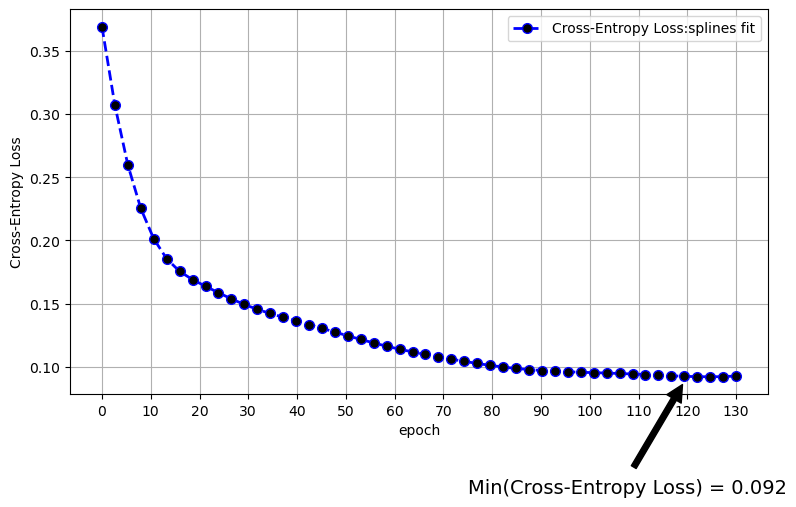

In [97]:
import csv_data
reload(csv_data)

from csv_data import SkyServerDatasetWrapper


# Load the data with 3 target values instead of the binary value from earlier
wrapper = SkyServerDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

# Setup our network with 3 outputs
net = ClassificationNet(3)
lr = 1e-3
epochs = 140

train_loss_data = []
valid_loss_data = []
epoch_data = []

for epoch in range(epochs):
    train_loss = 0
    for x, target in zip(train_x, train_y):
        # Run the softmax function over the output of the neural network
        pred = softmax(net.forward(x.reshape(1,-1)))

        encoded = encode(target)
        # Compute the gradient using the nll_grad function
        grad = multiclass_loss_grad(pred, encoded)
        train_loss += multiclass_loss(pred, encoded)

        # Update the network parameters
        net.backward(grad, lr)

    if epoch % 10 == 0:
        epoch_data.append(epoch)
        train_loss_data.append(train_loss / len(train_x))
        valid_loss = 0
        for x, target in zip(valid_x, valid_y):
            pred = softmax(net.forward(x.reshape(1,-1)))
            encoded = encode(target)
            valid_loss += multiclass_loss(pred, encoded)

        valid_loss_data.append(valid_loss / len(valid_x))
        print(f"Epoch {epoch} train loss: {train_loss / len(train_x)} - Valid loss: {valid_loss / len(valid_x)}")

plot_data(epoch_data, valid_loss_data, smooth=True, y_label='Cross-Entropy Loss')

![green-divider](https://user-images.githubusercontent.com/7065401/52071924-c003ad80-2562-11e9-8297-1c6595f8a7ff.png)